## Baseline
---

```python
modeling_df = df[df["transaction_datetime"].between(pd.to_datetime('2020-05-01'),
                                                    pd.to_datetime('2020-07-31'))]
test_df = df[df["transaction_datetime"].between(pd.to_datetime('2020-08-01'),
                                                pd.to_datetime('2021-04-30'))]
```

In [1]:
import json, sys, os

sys.path.insert(1, "../..")
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

import matplotlib.pyplot as plt
import seaborn as sns
import smart_open

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

### Load Scored datasets

In [2]:
modeling_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_modeling_df.parquet')
test_df = pd.read_parquet('s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/2021-05-19/SCORED_test_df.parquet')

In [3]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [4]:
target_col = "is_returned"
pred_cols = ['deposit_v1_pred', 'customer_pred', 'score']
metrics = get_pred_reports(test_df, target_col, pred_cols)
metrics

,auc,ap,ks
deposit_v1_pred,83.29,28.84,52.69
customer_pred,87.44,40.94,60.24
score,90.84,52.85,67.32


(<Figure size 1152x432 with 2 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

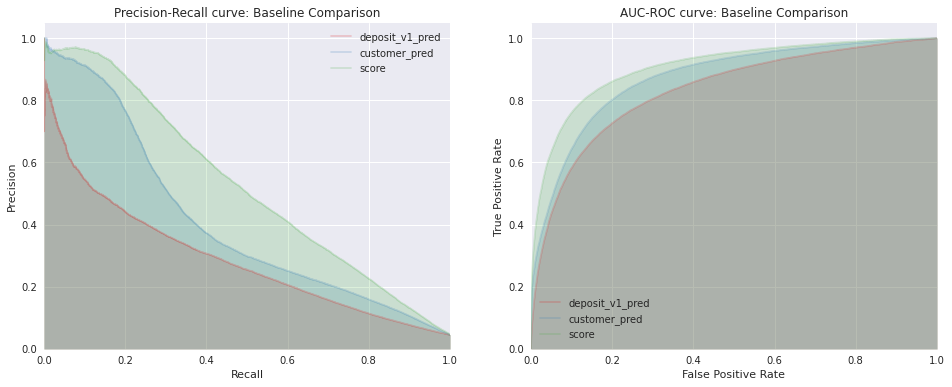

In [5]:
preds = [(test_df[col], col) for col in pred_cols]

fig, axs = plt.subplots(1, 2, figsize=(16,6))
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors=colors, 
                   ax=axs[1], fig=fig)

<AxesSubplot:>

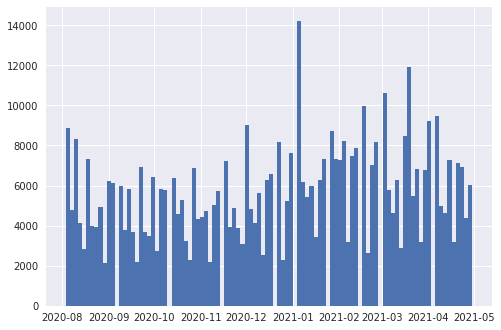

In [6]:
test_df.transaction_datetime.hist(bins=100)

========= month: 8 =========


,auc,ap,ks
deposit_v1_pred,84.45,31.12,55.19
customer_pred,88.67,50.02,63.34
score,92.27,63.01,71.51


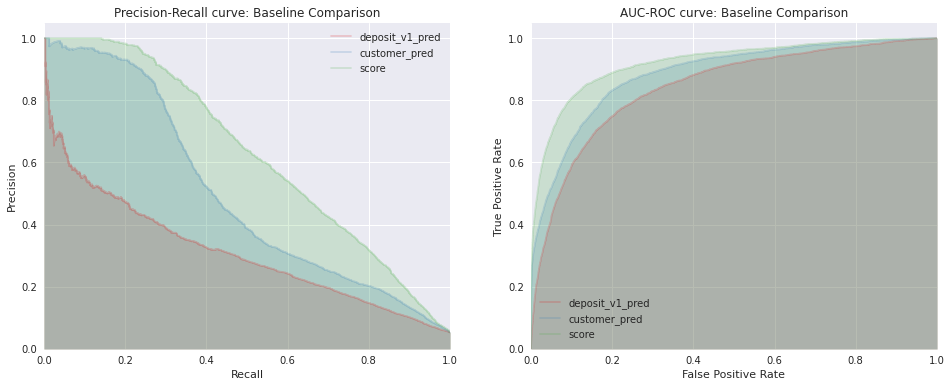

========= month: 9 =========


,auc,ap,ks
deposit_v1_pred,83.06,28.10,53.16
customer_pred,88.95,45.50,63.81
score,91.90,57.69,70.47


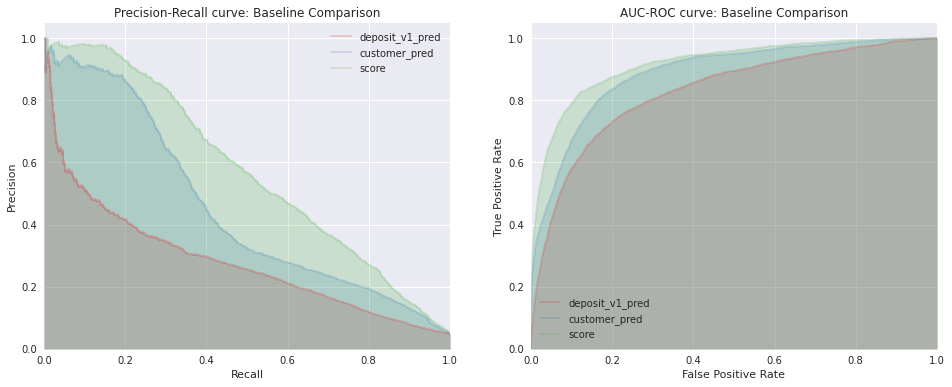

========= month: 10 =========


,auc,ap,ks
deposit_v1_pred,83.23,31.24,52.87
customer_pred,88.37,47.31,62.39
score,91.83,59.45,69.72


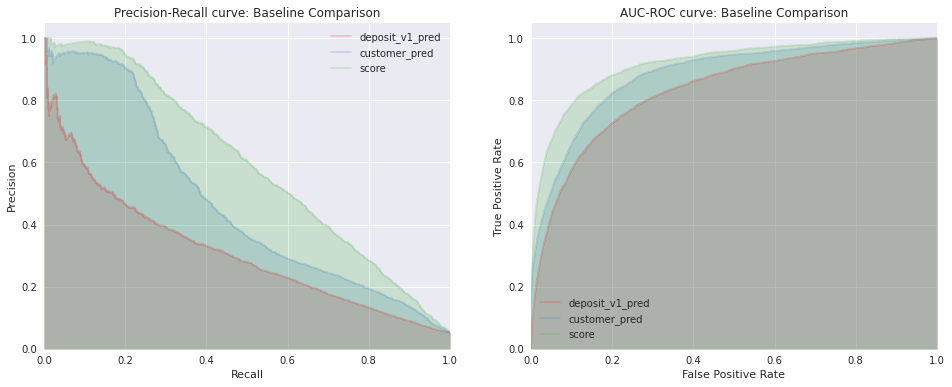

========= month: 11 =========


,auc,ap,ks
deposit_v1_pred,84.74,32.57,55.58
customer_pred,88.15,44.81,61.62
score,91.87,56.70,70.27


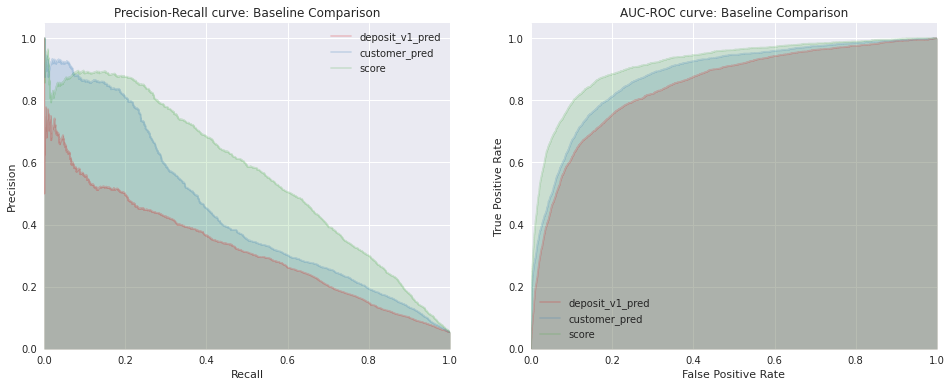

========= month: 12 =========


,auc,ap,ks
deposit_v1_pred,84.24,32.74,54.36
customer_pred,88.15,42.36,61.94
score,91.11,53.51,67.99


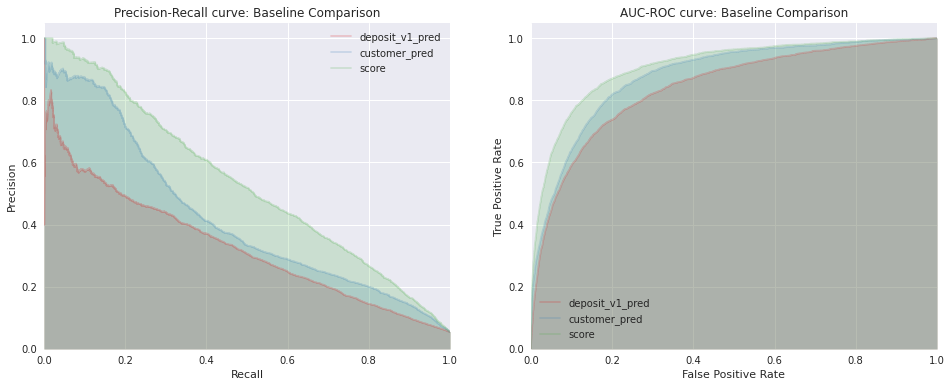

========= month: 1 =========


,auc,ap,ks
deposit_v1_pred,83.62,35.46,53.56
customer_pred,87.95,44.76,61.01
score,90.33,51.18,65.88


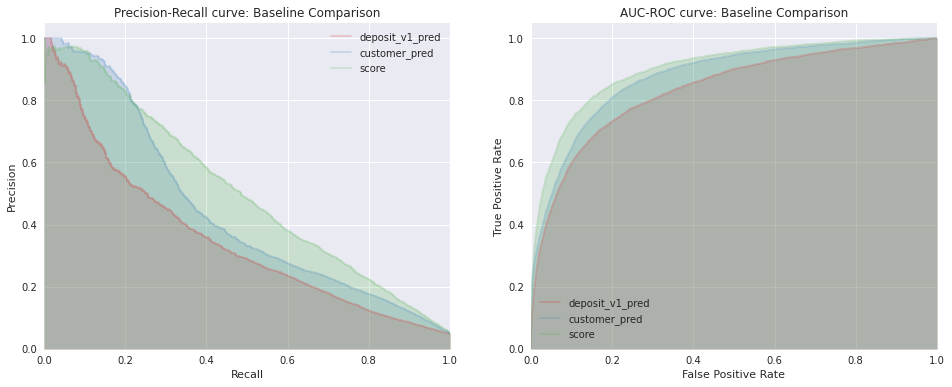

========= month: 2 =========


,auc,ap,ks
deposit_v1_pred,80.90,19.91,48.32
customer_pred,85.80,31.20,57.03
score,89.57,42.85,64.23


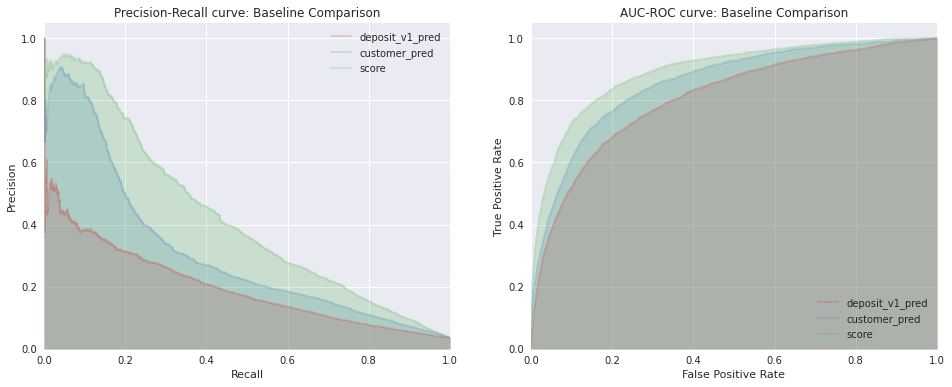

========= month: 3 =========


,auc,ap,ks
deposit_v1_pred,81.88,23.40,49.96
customer_pred,85.03,29.51,55.99
score,88.92,42.74,63.47


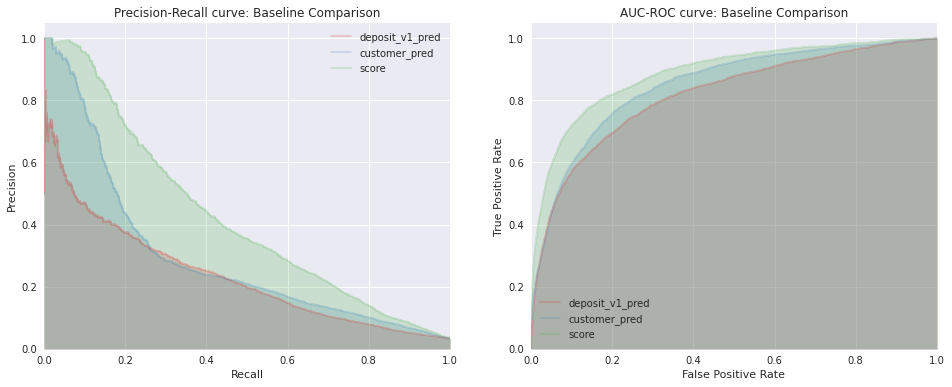

========= month: 4 =========


,auc,ap,ks
deposit_v1_pred,81.70,21.59,50.21
customer_pred,84.45,31.26,54.56
score,88.74,44.25,63.53


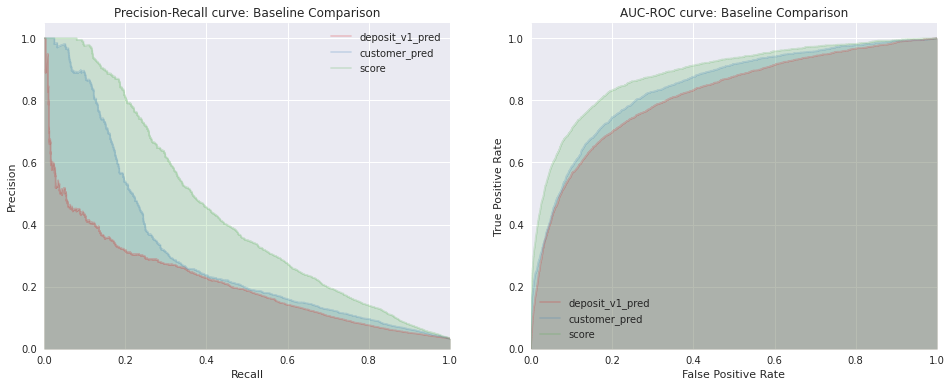

In [7]:
for m in test_df.transaction_datetime.dt.month.unique():
    print(f"========= month: {m} =========")
    test_df_ = test_df[test_df.transaction_datetime.dt.month == m]
    preds = [(test_df_[col], col) for col in pred_cols]
    targets = test_df_[target_col]

    metrics = get_pred_reports(test_df_, target_col, pred_cols)
    display(metrics)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    cmap = plt.get_cmap('Set1')
    colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

    title = 'Precision-Recall curve: Baseline Comparison'
    plot_pr_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[0], fig=fig) 

    title = 'AUC-ROC curve: Baseline Comparison'
    plot_auc_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[1], fig=fig)
    
    plt.show()

#### Quarterly Behavior

========= month: [8, 9] =========


,auc,ap,ks
deposit_v1_pred,83.86,29.77,54.29
customer_pred,88.81,48.08,63.56
score,92.11,60.70,70.80


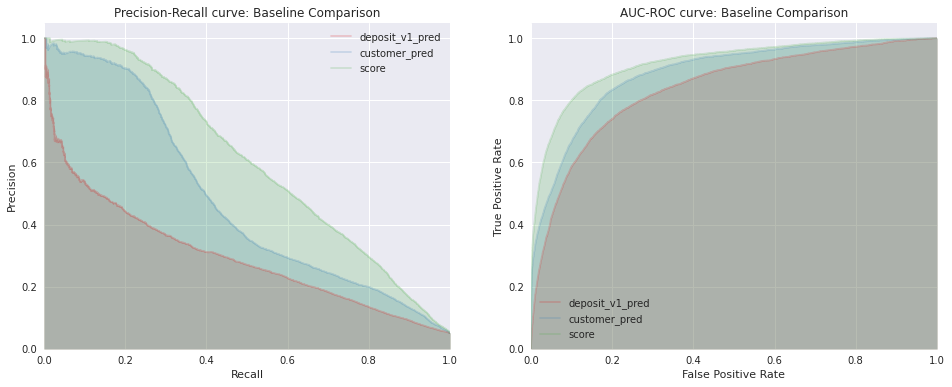

========= month: [10, 11, 12] =========


,auc,ap,ks
deposit_v1_pred,84.09,32.16,54.09
customer_pred,88.20,44.64,61.80
score,91.59,56.32,69.14


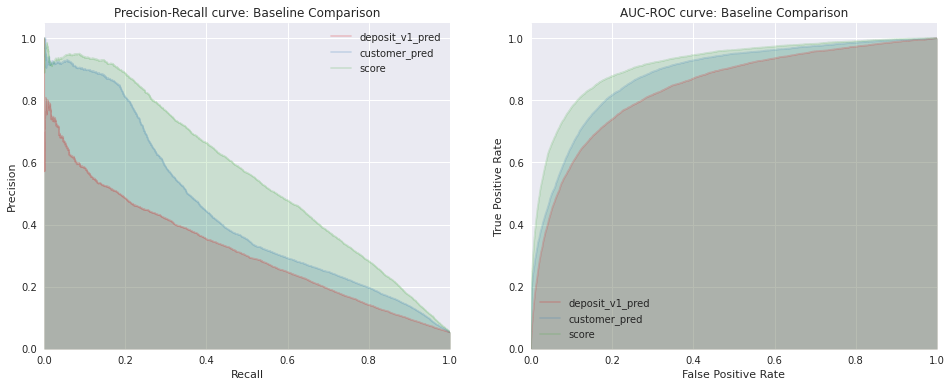

========= month: [1, 2, 3] =========


,auc,ap,ks
deposit_v1_pred,82.33,27.08,50.74
customer_pred,86.47,35.82,58.29
score,89.68,45.99,64.56


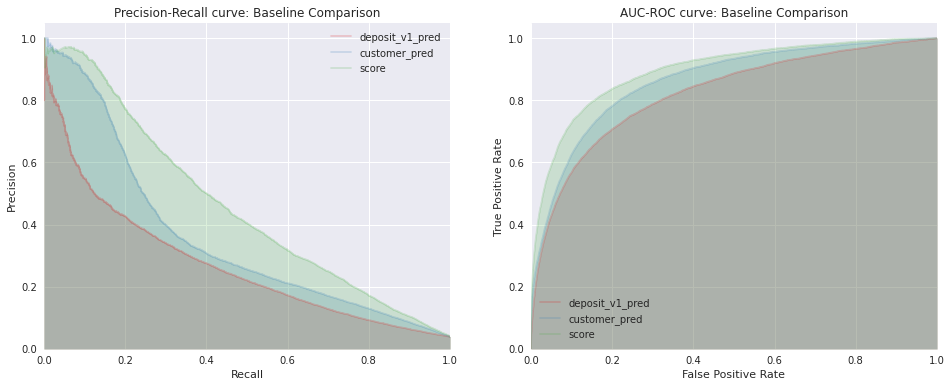

========= month: [4] =========


,auc,ap,ks
deposit_v1_pred,81.70,21.59,50.21
customer_pred,84.45,31.26,54.56
score,88.74,44.25,63.53


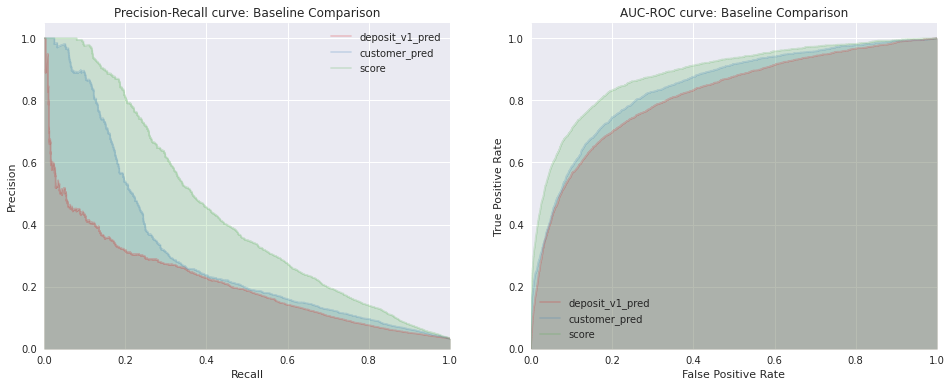

In [9]:
months = [[8,9], [10, 11, 12], [1,2,3], [4]]
for m in months:
    print(f"========= month: {m} =========")
    test_df_ = test_df[test_df.transaction_datetime.dt.month.isin(m)]
    preds = [(test_df_[col], col) for col in pred_cols]
    targets = test_df_[target_col]

    metrics = get_pred_reports(test_df_, target_col, pred_cols)
    display(metrics)
    
    fig, axs = plt.subplots(1, 2, figsize=(16,6))
    cmap = plt.get_cmap('Set1')
    colors = [cmap(i) for i in range(len(preds))]# np.linspace(0, 1, len(preds))]

    title = 'Precision-Recall curve: Baseline Comparison'
    plot_pr_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[0], fig=fig) 

    title = 'AUC-ROC curve: Baseline Comparison'
    plot_auc_curve_mult(targets, preds,
                       title=title, colors=colors, 
                       ax=axs[1], fig=fig)
    
    plt.show()